In [1]:
import pandas as pd
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ks_kampus.csv')
df = df.drop(['emojis', 'reply_count', 'retweet_count', 'like_count'], axis=1)
df = df[df.columns[1:]].dropna()

In [3]:
from datetime import datetime
import time

def datetime_from_utc_to_local(utc_datetime):
    now_timestamp = time.time()
    offset = datetime.fromtimestamp(now_timestamp) - datetime.utcfromtimestamp(now_timestamp)
    return utc_datetime + offset

df.post_date = pd.to_datetime(df.post_date)
df.post_date = df.post_date.apply(lambda x: datetime_from_utc_to_local(x))

In [4]:
df.drop_duplicates(subset=["username", "post_date"], inplace=True)
df

,account_name,username,post_date,tweet
0,hy friends | kinda ia bcs sibok ya miskah,@cupidnyamrkhyck,2021-12-03 19:03:58+00:00,aneh kan? bukannya pelaku kekerasan seksual yg...
1,eri𝒜ul,@eriaul,2021-12-03 18:58:39+00:00,Replying to \n@urijonginini\nemg banyak ka ga ...
2,Avogadro,@galaktosaaa,2021-12-03 18:45:08+00:00,ditengah banyaknya kasus pelecehan seksual tak...
3,KPM Unpad,@kpmunpad,2021-12-03 18:34:05+00:00,8. Webinar Series 6 Pembinaan Mental Kebangsaa...
4,tiara.,@yaelahbraaay,2021-12-03 18:17:10+00:00,"liat berita kampus w dongkol sendiri, emang da..."
...,...,...,...,...
1664,Han,@Han96147158,2021-11-10 16:35:57+00:00,Saya disini juga menolak adanya kekerasan seks...
1665,🜲⸳ 𓂃 ⴰ⭑ุ,@Hyung__taehyung,2021-11-10 16:35:52+00:00,para orang tua dari dulu sangat khawatir anak ...
1666,kaliya,@KY12OO4,2021-11-10 16:35:46+00:00,Komitmen perguruan tinggi akan terbentuk denga...
1667,PanggilajaRJ,@RJanakbapakJin,2021-11-10 16:35:41+00:00,Sebagai seorang mahasiswa saya juga merasa mir...


In [5]:
df_original = df.copy()

df.shape

(1626, 4)

In [6]:
mapper = pd.read_csv('new_kamusalay.csv', encoding='ISO-8859-1')
mapper.set_index(mapper['anakjakartaasikasik'], inplace=True)
mapper.drop(['anakjakartaasikasik'], axis=1, inplace=True)
mapper = mapper.T.to_dict('records')[0]
mapper.update({'permen': 'permendikbud'}) # tambahan

In [7]:
# O(n) -> O(1) dengan hash table!

stopword = pd.read_csv('stopwordbahasa.csv')
stopword['True'] = True
stopword.set_index(stopword['ada'], inplace=True)
stopword.drop(['ada'], axis=1, inplace=True)
stopword = stopword.T.to_dict('records')[0]

add_stopword = ['ada', 'nih', 'nya', 'sih', 'oi', 
                'ya', 'kayak', 'and', 'others', 'selengkapnya']
                
for key in add_stopword:
    stopword.update({key: True})

In [8]:
def preprocess(tweet, mapper, stopword):
    tweet = tweet.replace("\n", " ").strip().lower()
    
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet) # Buang links
    # Cleaning my bad scrapping :)
    tweet = re.sub(r'[^\s]*.com', '', tweet)
    tweet = re.sub(r'the following media includes potentially sensitive content. change settings', '', tweet)
    tweet = re.sub(r'replying to', '', tweet)
    tweet = re.sub(r'and others', '', tweet)
    tweet = re.sub(r'show this thread', '', tweet)

    tweet = re.sub(r'@[^\s\n\t]+', '', tweet) # Buang mentions
    tweet = re.sub(r'\d+', '', tweet) # Buang digits
    tweet = re.sub(r'[^\s\w]', ' ', tweet) # Buang nonalpha char e.g. "/", "?", "#"

    tweet = tweet.strip().split()
    i = 0
    while i < len(tweet):
        replace = mapper.get(tweet[i])
        if replace:
            tweet[i] = replace
        
        if stopword.get(tweet[i]):
            tweet.pop(i)
        else:
            i += 1
        

    return ' '.join(tweet)

In [9]:
df.tweet = df.tweet.apply(lambda x: preprocess(x, mapper, stopword))

In [10]:
df

,account_name,username,post_date,tweet
0,hy friends | kinda ia bcs sibok ya miskah,@cupidnyamrkhyck,2021-12-03 19:03:58+00:00,aneh pelaku kekerasan seksual dicoret namanya ...
1,eri𝒜ul,@eriaul,2021-12-03 18:58:39+00:00,kakak unsri unsri tak tau valid pelecehan seks...
2,Avogadro,@galaktosaaa,2021-12-03 18:45:08+00:00,ditengah banyaknya pelecehan seksual dterlepas...
3,KPM Unpad,@kpmunpad,2021-12-03 18:34:05+00:00,webinar series pembinaan mental kebangsaan mar...
4,tiara.,@yaelahbraaay,2021-12-03 18:17:10+00:00,lihat berita kampus gue dongkol iya internalny...
...,...,...,...,...
1664,Han,@Han96147158,2021-11-10 16:35:57+00:00,di sini menolak kekerasan seksual dilingkungan...
1665,🜲⸳ 𓂃 ⴰ⭑ุ,@Hyung__taehyung,2021-11-10 16:35:52+00:00,orang tua khawatir anak gadisnya korban kekera...
1666,kaliya,@KY12OO4,2021-11-10 16:35:46+00:00,komitmen perguruan terbentuk terbitnya peratur...
1667,PanggilajaRJ,@RJanakbapakJin,2021-11-10 16:35:41+00:00,mahasiswa miris berita marak sosial media medi...


In [11]:
# Tweet terlawas: 10 November 2021
# Bertepatan sehari setelah Nadiem Makarim ada di Mata Najwa
df.post_date.tail(1)

1668   2021-11-10 16:35:41+00:00
Name: post_date, dtype: datetime64[ns, UTC]

In [12]:
# Tweet terbaru: 03 Desember 2021
# Kasus terbaru Universitas Sriwijaya
df.post_date.head(1)

0   2021-12-03 19:03:58+00:00
Name: post_date, dtype: datetime64[ns, UTC]

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

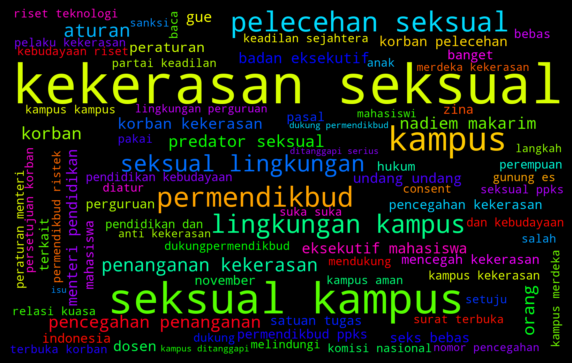

In [14]:
all_txt = ' '.join(df.tweet.tolist())
wordcloud = WordCloud(colormap = 'gist_rainbow', height=1000, width=1600, 
                    max_font_size=200, background_color='black',
                    min_font_size=24).generate(all_txt)

plt.figure(figsize = (10, 8), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
print("Total karakter:", len(all_txt))
print("Total kata:", len(all_txt.split()))

Total karakter: 272809
Total kata: 33173


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set()

In [17]:
def ngram_plot(sentences, ngram_range=(1,3), top=10, firstword=''):
    c = CountVectorizer(ngram_range=ngram_range)
    X = c.fit_transform(sentences)
    words = pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).\
                        T.sort_values(0,ascending=True).reset_index()
    res = words[words['index'].apply(lambda x: firstword in x)].tail(top)
    res.rename(columns={0: 'count'}, inplace=True)

    f, ax = plt.subplots(figsize=(10,5))
    ax.barh(res['index'], res['count'])
    ax.tick_params(axis="x", labelsize=12) 
    ax.tick_params(axis="y", labelsize=13) 
    plt.show()

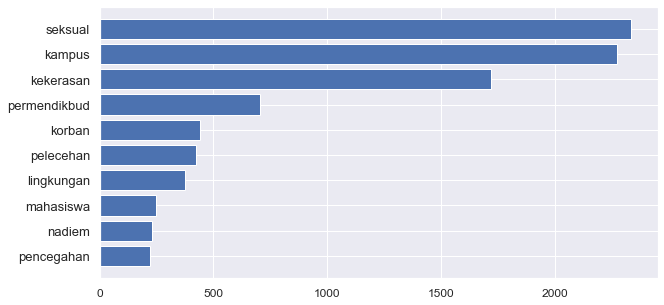

In [18]:
ngram_plot(df.tweet.tolist(), ngram_range=(1,1))

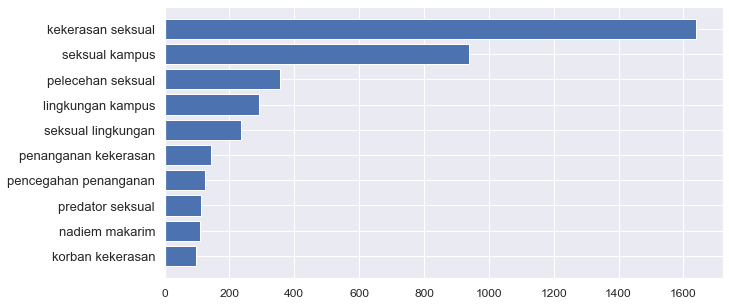

In [19]:
ngram_plot(df.tweet.tolist(), ngram_range=(2,2))

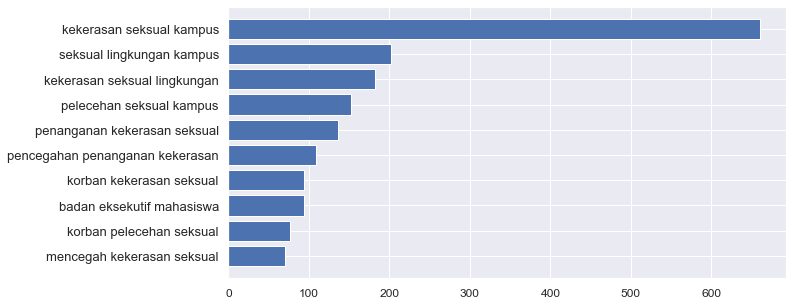

In [20]:
ngram_plot(df.tweet.tolist(), ngram_range=(3,3))

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

In [22]:
'''
    LSA and LDA taken from Ryan Cushen.
    Kaggle source code: https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda/notebook
'''

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, n_topics, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if not(isinstance(temp_vector_sum, int)):
            temp_vector_sum = temp_vector_sum.toarray()
            top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
            top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [23]:
def get_topics_lsa(filter, n_topics=10):
    data_filtered = df[df.tweet.str.contains(filter)]
    small_count_vectorizer = CountVectorizer()
    small_text_sample = data_filtered.tweet.values
    small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

    lsa_model = TruncatedSVD(n_components=n_topics)
    lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)
    lsa_keys = get_keys(lsa_topic_matrix)
    lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

    top_n_words_lsa = get_top_n_words(15, n_topics, lsa_keys, small_document_term_matrix, small_count_vectorizer)

    for i in range(len(top_n_words_lsa)):
        print("Topik {}: ".format(i+1), top_n_words_lsa[i])

In [24]:
def get_topics_lda(filter, n_topics=10):
    data_filtered = df[df.tweet.str.contains(filter)]
    small_count_vectorizer = CountVectorizer()
    small_text_sample = data_filtered.tweet.values
    small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
    lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)
    lda_keys = get_keys(lda_topic_matrix)
    lda_categories, lda_counts = keys_to_counts(lda_keys)
    
    top_n_words_lda = get_top_n_words(16, n_topics, lda_keys, small_document_term_matrix, small_count_vectorizer)

    for i in range(len(top_n_words_lda)):
        print("Topik {}: ".format(i+1), top_n_words_lda[i])

In [25]:
get_topics_lsa('kekerasan seksual')

Topik 1:  seksual kekerasan kampus permendikbud lingkungan korban pencegahan nadiem penanganan pendidikan peraturan ppks menteri aturan bebas
Topik 2:  mahasiswa badan eksekutif fakultas ilmu kekerasan kampus seksual fiction fib fia fh industri masyarakat politik
Topik 3:  menteri pendidikan kebudayaan kekerasan penanganan kampus pencegahan seksual peraturan nadiem makarim gusdurian dan riset teknologi
Topik 4:  permendikbud kampus seksual kekerasan kuhp skupnya seks aturan protes hukumnya bebas pinjol perkara undang peraturannya
Topik 5:  nadiem kampus menantang umat islam undang akreditasi ristek permendikbud makarim polisi pengamat kekerasan no agama
Topik 6:  korban persetujuan kampus seksual kekerasan zina was lingkungan pelecehan orang frasa tindakan mencegah pelaku pulih
Topik 7:  undang kampus seksual kekerasan rancangan keadilan partai sejahtera seks lingkungan permendikbud aturan bebas kuhp dewan
Topik 8:  tugas bandungbergerak permendikbudristek satuan ppks negeri id semaran

In [26]:
get_topics_lda('zina', 3)

Topik 1:  kampus seksual moral ganti zina undang konteks pernikahan berbeda standard meluas perzinaan kdrt paksa terkait kayaknya
Topik 2:  zinah kekerasan tua fathanah kampus tidur negara korupsi seksual anaknya rakyat orang kelompok at hi ruang
Topik 3:  kampus seksual kekerasan zina permendikbud korban undang aturan persetujuan perzinaan melegalkan lingkungan suka orang bebas seks


In [56]:
df[df.account_name.str.contains("KM")].shape[0]

9